# Generate synthetic data

This is a basic code to generate synthetic pressure seismic data via a finite difference solution of the second order scalar acoustic wave equation. The core code is found within ``scaas2d.cpp`` that is interfaced with python via pybind11. 

The subsurface wavespeed models were generated by the code ``mdlbuild.py`` in the resfoc repository. They were generated in a pseudo-random fashion.

## Set up imports

In [1]:
import scaas.defaultgeom as geom     # Modeling class
from scaas.wavelet import bandpass   # Creates wavelet
from scaas.trismooth import smooth   # Triangular smoother
from deeplearn.utils import resample # Resampling code (from resfoc)
import numpy as np
import wget                          # Module for downloading files (python-wget)
from os import path
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from genutils.plot import plot_wavelet  # Plotting utility (from resfoc)

## Download and plot velocity model

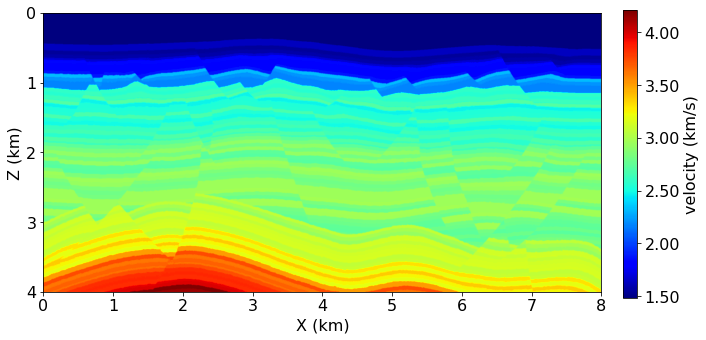

In [2]:
# Download and load the velocity models. This may take a minute or two.
if(not path.exists('vels.npy')):
    url = "http://sep.stanford.edu/data/media/public/sep/joseph29/vels.npy"
    vels = np.load(wget.download(url))
    vels = np.load('vels.npy')
else:
    vels = np.load('vels.npy')

# Choose one of the 10 velocity models in the file
vel = np.ascontiguousarray(vels[3,:,:].T)
nz = vel.shape[1]; dz = 4
nx = vel.shape[0]; dx = 8

# Plot the model
fsize = 16
fig = plt.figure(1,figsize=(10,10))
ax = fig.gca()
im = ax.imshow(vel/1000.0,cmap='jet',interpolation='bilinear',extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
tick_spacing = 1
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(labelsize=fsize)
cbar_ax = fig.add_axes([0.93,0.3,0.02,0.4])
cbar = fig.colorbar(im,cbar_ax,format='%.2f')
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('velocity (km/s)',fontsize=fsize)


## Resample the velocity model

I will resample the velocity model to a much smaller size to make the modeling more computationally affordable

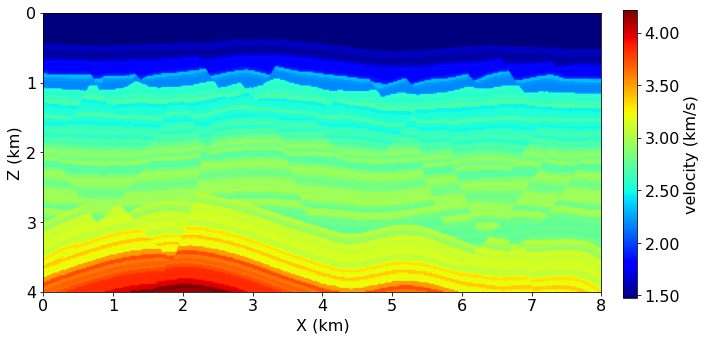

In [3]:
# Resample to a smaller size
nzo = 200; nxo = 400;
velsm,[dzo,dxo] = resample(vel,[nzo,nxo],kind='cubic',ds=[dz,dx])
velsm = velsm.astype('float32')

# Smooth with a five point smoother in each direction
velsmu = smooth(velsm,rect1=5,rect2=5)

fig = plt.figure(2,figsize=(10,10))
ax = fig.gca()
im = ax.imshow(velsmu/1000.0,cmap='jet',interpolation='bilinear',extent=[0,(nxo)*dxo/1000.0,(nzo)*dzo/1000.0,0.0])
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
tick_spacing = 1
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(labelsize=fsize)
cbar_ax = fig.add_axes([0.93,0.3,0.02,0.4])
cbar = fig.colorbar(im,cbar_ax,format='%.2f')
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('velocity (km/s)',fontsize=fsize)
plt.show()

## Setup acquisition and create wavelet

For an acquisition geometry, I place receivers at each gridpoint on the surface ($z=0$) and sources at every 200 m (10 gridpoints). I show an acquisition plot on the computational grid for QC. This plot shows the padding added for the absorbing layer as well as the positions of the sources and receivers. 

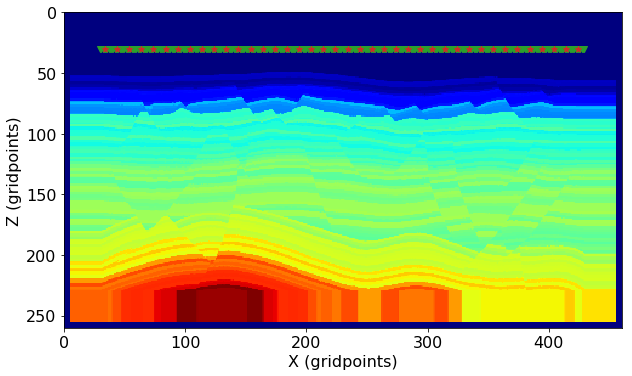

In [4]:
# Create wave propagation object with a standard synthetic geometry
prp = geom.defaultgeom(nxo,dxo,nzo,dzo,nsx=40,osx=4,dsx=10)

# Plot acquisition on grid for QC
prp.plot_acq(velsmu,labelsize=16)

For the wavelet I create a zero-phase wavelet with frequency range of 2-20 Hz and 4 seconds in length.

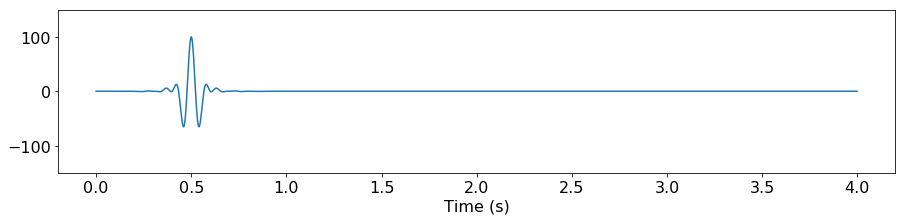

In [5]:
# Make and plot wavelet
ntu = 4000; dtu = 0.001; amp = 100 
wav = bandpass(ntu,dtu,[2,10,12,20],amp,0.5)
plot_wavelet(wav,dtu,hbox=3,labelsize=16)

## Forward modeling and plot data

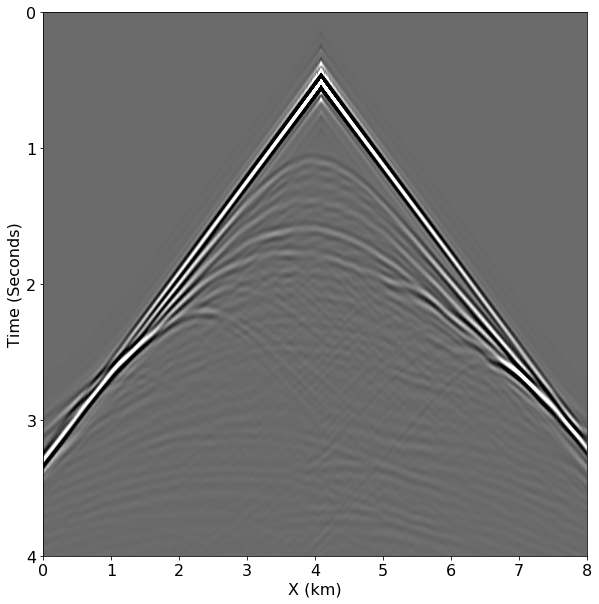

In [6]:
# Output data sampling and forward modeling
# With verb=True a progressbar will print out on the terminal from which you started the notebook
# You can change nthrds based on your computer hardware
dtd = 0.004
dat = prp.model_fulldata(velsmu,wav,dtd,dtu,verb=True)

fig = plt.figure(3,figsize=(10,10))
ax = fig.gca()
im = ax.imshow(dat[20,:,:],cmap='gray',interpolation='sinc',vmin=np.min(dat)*0.05,vmax=np.max(dat)*0.05,
               extent=[0,(nxo)*dxo/1000.0,(dat.shape[1])*dtd,0.0],aspect=2.0)
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Time (Seconds)',fontsize=fsize)
tick_spacing = 1
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(labelsize=fsize)
plt.show()